# Sheet 4

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## 3 QDA
### (a)

In [2]:
pts = np.load('data/data1d.npy')
labels = np.load('data/labels1d.npy')

In [3]:
zeros = pts[labels==0]
ones = pts[labels==1]

# Create normal ditribution
def create_nd(data, x):
    mean = np.mean(data)
    std = np.std(data)
    nd = 1 / (np.sqrt(2 * np.pi) * std) * np.exp(- (x - mean)**2 / (2 * std**2))
    return nd

### (b)

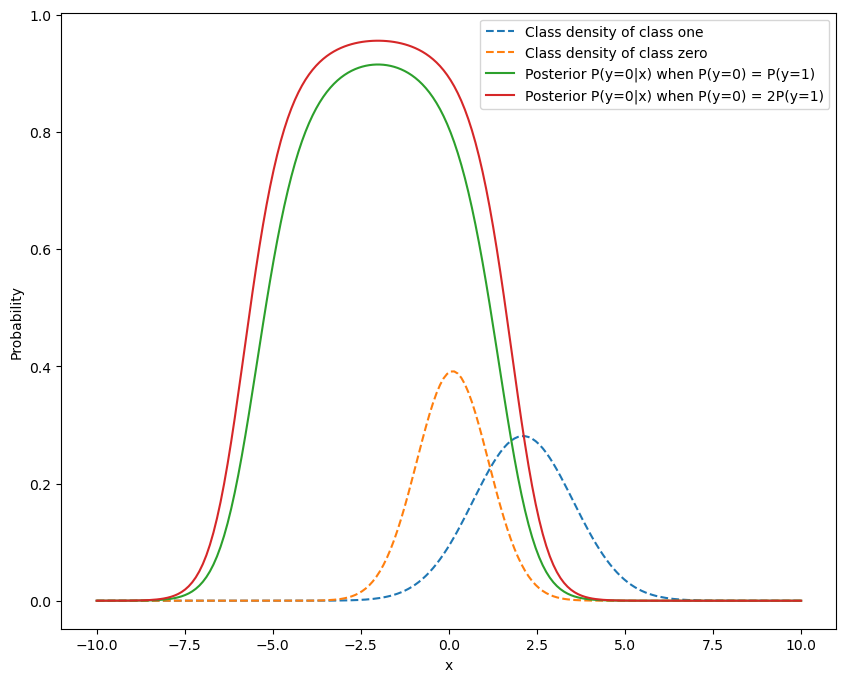

In [ ]:
# Calculate Posterior Probability P(y=0|x) when P(y=0) = P(y=1)
def posterior_a1(x):
    post = create_nd(zeros, x) / (create_nd(zeros, x) + create_nd(ones, x))
    return post

# Calculate Posterior Probability P(y=0|x) when P(y=0) = 2P(y=1)
def posterior_a2(x):
    post = 2/3*create_nd(zeros, x) / (2/3*create_nd(zeros, x) + 1/3*create_nd(ones, x))
    return post

# Plot 
x = np.linspace(-10, 10, 200)
plt.figure(figsize=(10, 8))
# Plot normal distribution
plt.plot(x, create_nd(ones, x), label='Class density of class one', linestyle='--')
plt.plot(x, create_nd(zeros, x), label='Class density of class zero', linestyle='--')
# Plot Posterior
plt.plot(x, posterior_a1(x), label='Posterior P(y=0|x) when P(y=0) = P(y=1)')
plt.plot(x, posterior_a2(x), label='Posterior P(y=0|x) when P(y=0) = 2P(y=1)')

plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()

The Posterior probabilities are centered at around x=-2.5, the posterior probablity under the second assumption is higher and broader than the posterior porbabilty under the first assumption. This makes sense, because the class y=0 is more likely under the second assumption. '

## 4 Trees and Random Forests

### (b)

Best Gini Split: 1.7325847083983494
Best Entropy Split: 1.8174885383195665
Best Missclassification Split: 0.6174029972036599


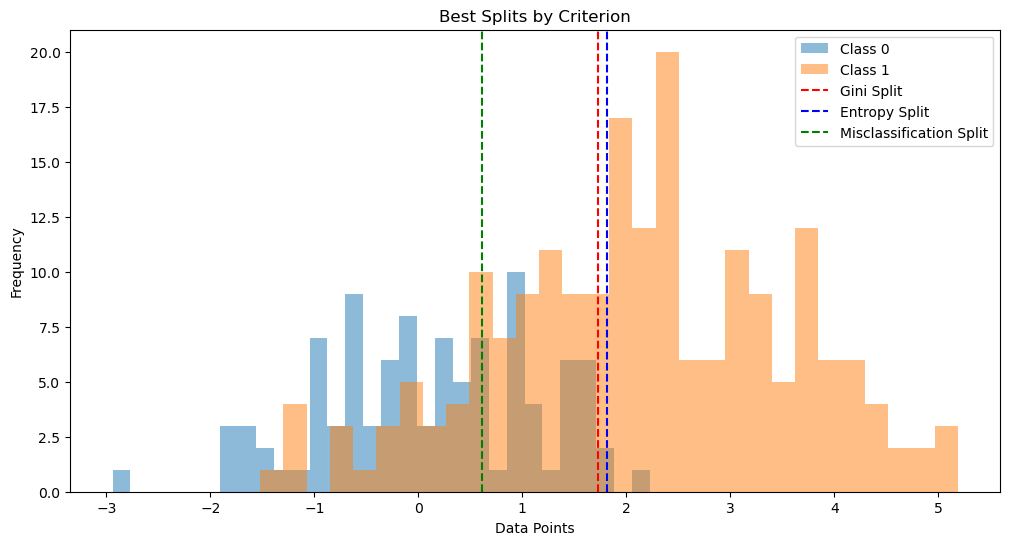

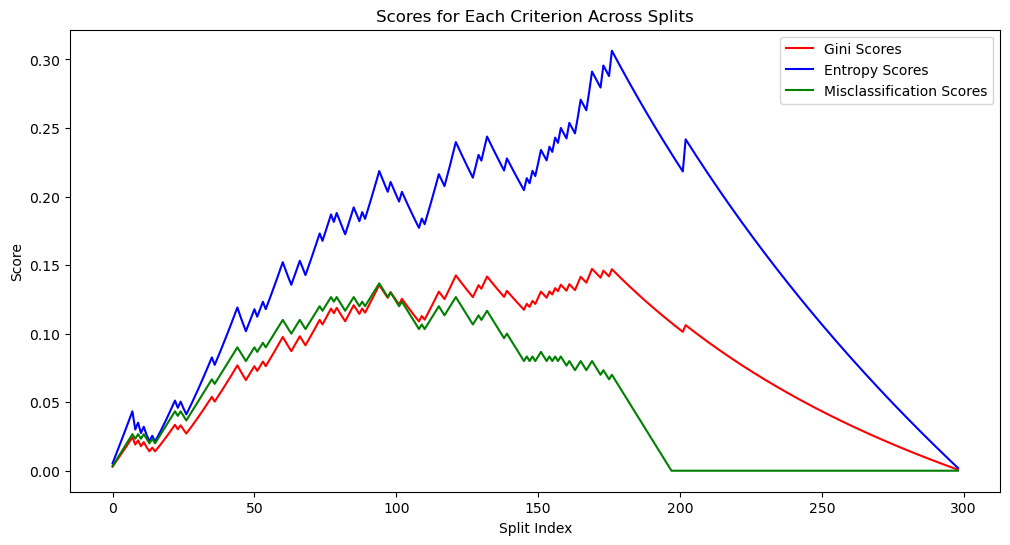

In [13]:
# load the data
pts = np.load('data/data1d.npy')
labels = np.load('data/labels1d.npy')

# Sort the points to easily split them
sort_idx = np.argsort(pts)
pts_sorted = pts[sort_idx]
labels_sorted = labels[sort_idx]

# TODO: Implement or find implementation for Gini impurity, entropy and misclassifcation rate
def gini(p):
    return 1 - np.sum(p**2)

def entropy(p):
    return -np.sum(p * np.log2(p, where=p > 0))

def misclassification(p):
    return 1 - np.max(p)


def probabilities(partition):
    # divide counts by size of dataset to get cluster probabilites
    return np.unique(partition, return_counts=True)[1] / len(partition)

def compute_split_measure(l, l0, l1, method):
    p0 = probabilities(l0)
    p1 = probabilities(l1)
    p = probabilities(l)
    return method(p) - (len(l0) * method(p0) + len(l1) * method(p1)) / (len(l))

# TODO: Iterate over the possible splits, evaulating and saving the three criteria for each one

def find_best_split(pts, labels, measure):
    best_split = None
    best_score = 0
    scores = []

    # Iterate over all possible splits
    for i in range(1, len(pts)):
        l0, l1 = labels[:i], labels[i:]
        l = labels
        score = compute_split_measure(l, l0, l1, measure)
        scores.append(score)

        if score > best_score:
            best_score = score
            best_split = pts[i]

    return best_split, scores

gini_split, gini_scores = find_best_split(pts_sorted, labels_sorted, gini)
entropy_split, entropy_scores = find_best_split(pts_sorted, labels_sorted, entropy)
misclassification_split, misclassification_scores = find_best_split(pts_sorted, labels_sorted, misclassification)

# TODO: Then, Compute the split that each criterion favours and visualize them 
#       (e.g. with a histogram for each class and vertical lines to show the splits)
# Plot the results
plt.figure(figsize=(12, 6))

# Plot the histogram of data points
plt.hist(pts_sorted[labels_sorted == 0], bins=30, alpha=0.5, label='Class 0')
plt.hist(pts_sorted[labels_sorted == 1], bins=30, alpha=0.5, label='Class 1')

# Add vertical lines for the splits
plt.axvline(gini_split, color='red', linestyle='--', label='Gini Split')
plt.axvline(entropy_split, color='blue', linestyle='--', label='Entropy Split')
plt.axvline(misclassification_split, color='green', linestyle='--', label='Misclassification Split')

print(f"Best Gini Split: {gini_split}")
print(f"Best Entropy Split: {entropy_split}")
print(f"Best Missclassification Split: {misclassification_split}")

plt.legend()
plt.xlabel('Data Points')
plt.ylabel('Frequency')
plt.title('Best Splits by Criterion')
plt.show()

# Visualize scores for each criterion
plt.figure(figsize=(12, 6))
plt.plot(gini_scores, label='Gini Scores', color='red')
plt.plot(entropy_scores, label='Entropy Scores', color='blue')
plt.plot(misclassification_scores, label='Misclassification Scores', color='green')
plt.xlabel('Split Index')
plt.ylabel('Score')
plt.title('Scores for Each Criterion Across Splits')
plt.legend()
plt.show()

### (b)

In [46]:
# load the dijet data
features = np.load('data/dijet_features_normalized.npy')
labels = np.load('data/dijet_labels.npy')

# TODO: define train, val and test splits as specified (make sure to shuffle the data before splitting it!)
print(np.shape(labels))

indices = np.random.permutation(len(labels))

features[:] = features[:,indices]
labels[:] = labels[indices]

validation = features[:,:200]
validation_labels = labels[:200]
test = features[:,200:400]
test_labels = labels[200:400]
train = features[:,400:]
train_labels = labels[400:]

print(f"Validation shape = {np.shape(validation)}, Test shape = {np.shape(test)}, Train shape = {np.shape(train)}")

(2233,)
Validation shape = (116, 200), Test shape = (116, 200), Train shape = (116, 1833)


In [45]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
# TODO: train a random forest classifier for each combination of specified hyperparameters 
#       and evaluate the performances on the validation set.
Ntrees = [5, 10, 20, 100]
criterions = ['gini','entropy']
max_depth = [2, 5, 10, None]

scores = []
parameters = []

for N in Ntrees:
    for c in criterions:
        for d in max_depth:
            # training 
            rf = RandomForestClassifier(n_estimators=N,criterion=c,max_depth=d)
            rf.fit(train.T,train_labels)

            # validation 
            validation_prediction = rf.predict(validation.T)
            score = sum(np.where(validation_prediction==validation_labels,1,0))/len(validation_labels)
            scores.append(score)
            parameters.append((N,c,d))

max_score_index = np.argmax(scores)
highest_score_param = parameters[max_score_index]

print(f"Highest scoring parameters: {highest_score_param}, with score: {scores[max_score_index]}")

Highest scoring parameters: (100, 'entropy', None), with score: 0.8


In [48]:
# TODO: for your preferred configuration, evaluate the performance of the best configuration on the test set
b_rf = RandomForestClassifier(n_estimators=highest_score_param[0],criterion=highest_score_param[1],max_depth=highest_score_param[2])
b_rf.fit(train.T,train_labels)

test_prediction = rf.predict(test.T)
score = sum(np.where(test_prediction==test_labels,1,0))/len(test_labels)

print(f"Ranfom Forest with choosen Hyperparameters classification score: {score}, (where 1 is perfect)")

Ranfom Forest with choosen Hyperparameters classification score: 0.795, (where 1 is perfect)
